In [1]:
import ast
import os
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, LSTM
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from plot_util import plot_confusion_matrix
%matplotlib inline

# Model parameters
MAX_FEATURES = 256404
MAX_TEXT_LENGTH = 1024
EMBED_SIZE  = 100
BATCH_SIZE = 128
EPOCHS = 2
VALIDATION_SPLIT = 0.1

Using TensorFlow backend.


Nous définissons la fonction pour lire le jeu de données et faire le découpage d'apprentissage et test. 

In [2]:
def split_datasets(data_paths, test_size):
    x = []
    y = []
    for data_path in data_paths:
        with open(data_path, 'r') as f:
            for line in f:
                temp = line.split('__label__')
                x.append(temp[0])
                y.append(temp[1].replace('\n', ''))
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print('Dataset splited.')
    return x_train, x_test, y_train, y_test

Pour construire le pipeline, nous allons d'abord définir des fonctions pour pré-traiter les données.

Nous allons tokenizer les données et nous mettrons les données et les labels au format propre pour le réseau de neurones. Les labels seront transmis aux vecteurs one-hot. Les données seront tokenizées et mises à la même longueur. Nous coupons les exemples trop longs et nous utilisons zero-padding pour les exemples courts.

In [3]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of training examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

Nous définissons la fonction pour lire les vecteurs de mots pré-appris. Nous construissons aussi la matrice d'entrée depuis x_train et les vecteurs de mots. Cette partie est basé sur le [tutoriel de Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) 

In [4]:
def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix

Nous définissons un modèle de classification de texte avec une couche de Conv1D et une couche de Dense. Nous pouvons utiliser les vecteurs de mots pré-appris. Le modèle est basé sur le [TP de M. Kermorvant](https://gitlab.com/kermorvant/nlp-labs) et https://github.com/gaussic/text-classification-cnn-rnn.

In [13]:
def get_model(embedding_matrix, word_index, print_sum=True):

    inp = Input(shape=(MAX_TEXT_LENGTH,))

    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    #model = Dropout(0.2)(model)
    model = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(model)
    model = Dropout(0.5)(model)
    model = MaxPooling1D(pool_size=2)(model)
    #model = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(model)
    #model = Dropout(0.5)(model)
    #model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(11, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if print_sum:
        model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y_train):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1)

    return model.predict(x_test)

Nous plottons la matrice de confusion, code basé sur [l'exemple de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

In [6]:
def plot_conf_mat(y_test, y_predicted):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')

Nous construissons le pipeline pour evaluer la qualité des vecteurs de mots.

In [7]:
def evaluation(vectors_file_path, print_sum=True, plot_mat=True):
    embedding_index = get_embedding_index(vectors_file_path)
    embedding_matrix = get_embedding_matrix(word_index, embedding_index)
    print('Building model...')
    model = get_model(embedding_matrix, word_index, print_sum=print_sum)
    y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
    print("Test Accuracy:", accuracy_score(y_test, y_predicted))
    if plot_mat:
        plot_conf_mat(y_test, y_predicted)
    return accuracy_score(y_test, y_predicted)

Maintenant, nous allons lire le jeu de données *[news_fastexttext_test.txt](https://drive.google.com/open?id=1psrAH5heISv3t2xuB4YKxUCvsUN6yU6C)* et *[news_less_category.txt](https://drive.google.com/open?id=11kUgD4HhqRqhEhS_6yTx_QOXKCWGF3U8)*, puis faire le découpage afin d'obtenir le jeu de données d'apprentissage utilisé et le jeu de données de test utilisé.

In [8]:
data_paths = ['datasets/news_less_category.txt', 'datasets/news_fasttext_test.txt']
test_size = 0.1
x_train, x_test, y_train, y_test = split_datasets(data_paths, test_size)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)

Dataset splited.
Label categories: ['affairs' 'economic' 'edu' 'ent' 'fashion' 'game' 'home' 'house'
 'science' 'sports' 'stock']
Converting data to trainable form...
Number of training examples: 192022
Number of training examples: 21336


D'abord, nous faisons un exemple d'évaluations en utilisant *word2vec_skip*.

Found 256403 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 1024, 100)         69204400  
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1024, 32)          16032     
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024, 32)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 512, 32)           0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 16384)             0         
____________________________________________

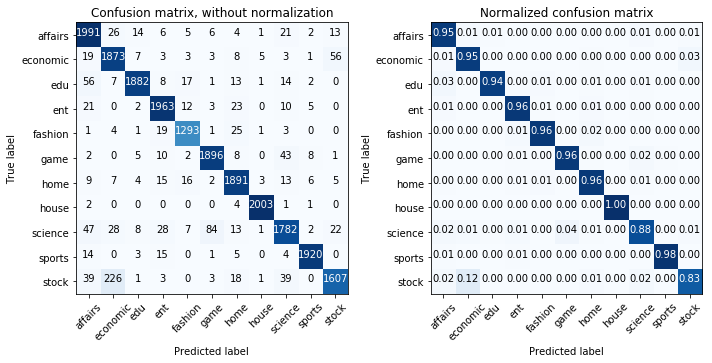

In [14]:
vectors_file_path = 'pre_trained_vectors/word2vec_skip.txt'
embedding_index = get_embedding_index(vectors_file_path)
embedding_matrix = get_embedding_matrix(word_index, embedding_index)
print('Building model...')
model = get_model(embedding_matrix, word_index)
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))
plot_conf_mat(y_test, y_predicted)

Nous allons évaluer la performance de chaque méthode.

In [15]:
methods = ['pre_trained_vectors/fasttext_skip.vec', 
           'pre_trained_vectors/fasttext_cbow.vec',
           'pre_trained_vectors/word2vec_skip.txt',
           'pre_trained_vectors/word2vec_cbow.txt',
           'pre_trained_vectors/glove.txt']
accuracies = {}
for vector_file in methods:
    acc = evaluation(vector_file, print_sum=False, plot_mat=False)
    method = vector_file.split('/')[1].split('.')[0]
    accuracies[method] = acc
print()
print('========================================================')
for meth, acc in accuracies.items():
    print('Test Accuracy of %s: %f' % (meth, acc))

Found 256404 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
Epoch 1/2
192022/192022 [==============================] - 19s 100us/step - loss: 0.3094 - acc: 0.9091
Epoch 2/2
192022/192022 [==============================] - 18s 93us/step - loss: 0.1800 - acc: 0.9457
Test Accuracy: 0.9506467941507312
Found 256404 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
Epoch 1/2
192022/192022 [==============================] - 19s 100us/step - loss: 0.5171 - acc: 0.8707
Epoch 2/2
192022/192022 [==============================] - 18s 93us/step - loss: 0.2513 - acc: 0.9260
Test Accuracy: 0.938413948256468
Found 256403 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
Epoch 1/2
192022/192022 [==============================] - 19s 101us/step - loss: 0.3426 - acc: 0.8965
Epoch 2/2
192022/192022 [==============================] - 18s 93us/step - loss: 0.1931 - acc: 0.9416
Test Accuracy: 0.9483502

Les résultats nous ont montrés que la méthode SkipGram a eu une meilleur performance, avec n'import quelle méthode. Au contraire, CBOW n'est pas assez performant. GloVe est presque pareil que CBOWs.